In [6]:
import keras
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras import layers
# from keras.layers import (LSTM, 
#                           Embedding, 
#                           BatchNormalization,
#                           Dense, 
#                           TimeDistributed, 
#                           Dropout, 
#                           Bidirectional,
#                           Flatten, 
#                           GlobalMaxPool1D)

from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
tf.test.is_gpu_available()

True

In [8]:
keras.__version__

'2.3.1'

In [9]:
def plot(history, arr):

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [10]:
# dataset = pd.read_csv('../input/nlp-getting-started/train.csv')
# test = pd.read_csv('../input/nlp-getting-started/test.csv')
# submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

dataset = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [11]:
train = dataset.text.values
test = test.text.values
sentiments = dataset.target.values

In [12]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train)
vocab_length = len(word_tokenizer.word_index) + 1

In [13]:
def metrics(pred_tag, y_test):

    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [14]:
longest_train = max(train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train), length_long_sentence, padding='post')

test_sentences = pad_sequences(
    embed(test), 
    length_long_sentence,
    padding='post'
)

In [15]:
# #Twitter Gloves

embeddings_dictionary = dict()
embedding_dim = 200
# glove_file = open('../input/glove-global-vectors-for-word-representation/glove.6B.' + str(embedding_dim) + 'd.txt', encoding="utf8")
glove_file = open('glove.twitter.27B.' + str(embedding_dim) + 'd.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [16]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    if index >= vocab_length:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence,
                        trainable=False))
    
    model.add(Bidirectional(LSTM(16)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [18]:
tf.test.is_gpu_available() 

True

In [19]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence,
                        trainable=False))
    
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose =1, 
    patience=5,                        
    min_lr=0.001
)

for idx in range(5):
    
    print("*"*20 + '\nModelo: ' + str(idx) + '\n')
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        verbose =1, 
        patience=5,                        
        min_lr=0.001
    )
    checkpoint = ModelCheckpoint(
        'model_' + str(idx)+ '.h5', 
        monitor='val_loss',
        mode='auto',
        verbose=1,
        save_weights_only = True,
        save_best_only=True
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sentences, 
        sentiments, 
        test_size=0.5
    )
    
    model = BLSTM()
    model.fit(X_train,
              y_train,
              batch_size=32,
              epochs=15,
              validation_data=[X_test, y_test],
              callbacks = [reduce_lr, checkpoint],
              verbose=1)

********************
Modelo: 0

Train on 3806 samples, validate on 3807 samples
Epoch 1/15
3806/3806 [==============================] - 22s 6ms/step - loss: 0.7251 - accuracy: 0.6398 - val_loss: 0.6279 - val_accuracy: 0.6454

Epoch 00001: val_loss improved from inf to 0.62790, saving model to model_0.h5
Epoch 2/15
3806/3806 [==============================] - 21s 5ms/step - loss: 0.5611 - accuracy: 0.7391 - val_loss: 0.5352 - val_accuracy: 0.7962

Epoch 00002: val_loss improved from 0.62790 to 0.53515, saving model to model_0.h5
Epoch 3/15
3806/3806 [==============================] - 21s 5ms/step - loss: 0.5086 - accuracy: 0.7709 - val_loss: 0.5022 - val_accuracy: 0.7801

Epoch 00003: val_loss improved from 0.53515 to 0.50220, saving model to model_0.h5
Epoch 4/15
3806/3806 [==============================] - 20s 5ms/step - loss: 0.4640 - accuracy: 0.7916 - val_loss: 0.4417 - val_accuracy: 0.8182

Epoch 00004: val_loss improved from 0.50220 to 0.44168, saving model to model_0.h5
Epoch 5/

3806/3806 [==============================] - 21s 5ms/step - loss: 0.3610 - accuracy: 0.8500 - val_loss: 0.4752 - val_accuracy: 0.8148

Epoch 00008: val_loss did not improve from 0.43018
Epoch 9/15
3806/3806 [==============================] - 21s 5ms/step - loss: 0.3522 - accuracy: 0.8529 - val_loss: 0.4587 - val_accuracy: 0.8135

Epoch 00009: val_loss did not improve from 0.43018
Epoch 10/15
3806/3806 [==============================] - 21s 5ms/step - loss: 0.3477 - accuracy: 0.8605 - val_loss: 0.5145 - val_accuracy: 0.8048

Epoch 00010: val_loss did not improve from 0.43018
Epoch 11/15
3806/3806 [==============================] - 21s 5ms/step - loss: 0.3248 - accuracy: 0.8673 - val_loss: 0.4874 - val_accuracy: 0.8117

Epoch 00011: val_loss did not improve from 0.43018
Epoch 12/15
3806/3806 [==============================] - 21s 5ms/step - loss: 0.2892 - accuracy: 0.8791 - val_loss: 0.5390 - val_accuracy: 0.8093

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 000

In [23]:
%%time
from glob import glob
import scipy

x_models = []
labels = []

# Carregando os Modelos
for idx in glob('*.h5'):
    model = BLSTM()
    model.load_weights(idx)
    x_models.append(model)
    
# Predizendo Classes para o conjunto de Testes
for idx in x_models:
    preds = idx.predict_classes(test_sentences)
    labels.append(preds)

#Votando nas classes, baseando na moda estatística 
labels = scipy.stats.mode(labels)[0]
labels = np.squeeze(labels)   

CPU times: user 19.9 s, sys: 704 ms, total: 20.6 s
Wall time: 12.2 s


[1 1 1 ... 1 1 0]


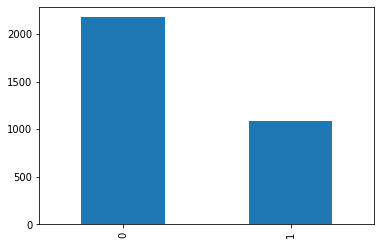

In [24]:
submission.target = labels
print(labels)
submission.to_csv("submission.csv", index=False)
submission.target.value_counts().plot.bar();

In [25]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
